In [11]:
##############################################################
# thanks to Habib Izadkhah for writing the following notebook#
# https://www.kaggle.com/habibizadkhah/newcat-gan            #
#                                                            #
# This was real easy to understand, taking inspiration from  #
# him and tensorflow org I managed to create this notebook   #
# on DCGAN                                                   #
# Thanks                                                     #
##############################################################

##############################################################
# This Notebook contains a deep Convolusional GAN            #
##############################################################


In [12]:
## Making some essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import cv2
import os
from tensorflow.keras import layers
from time import perf_counter

## Defining a data structure to store data and class names
dataStruct = {
                'categoryNames' : [],
                'ImageArr'      : []
    
}

## defining data loader function
def dataLoader(path = None, className = None, sizeSquare = 256):
    if path == None:
        return
    
    images = os.listdir(path)
    for image in images:
        loadPath = path + '/' + image
        img = plt.imread(loadPath)
        
        #resizing
        img = cv2.resize(img, (sizeSquare, sizeSquare))
        
        ## adjusting Value between -1 and 1
        img = (img - 127.5)/ 127.5
        dataStruct['categoryNames'].append(className)
        dataStruct['ImageArr'].append(img)
    
## defining a random vizualizer function
def visualizer():
    plt.figure(figsize = (14, 14))
    numImages = len(dataStruct['ImageArr'])
    randomChoices = np.random.randint(0, numImages, 16)
    
    pltnum = 1
    for choice in randomChoices:
        plt.subplot(4, 4, pltnum)
        plt.imshow(dataStruct['ImageArr'][choice])
        plt.title(dataStruct['categoryNames'][choice])
        pltnum += 1
    
    plt.show()
    return numImages

    
## defining certain params here 
## changes made here will be global
## to the script

imgHeight = 256
imgWeigth = 256
latentDim = 100
batchSize = 50

## defining descriminator first
def BuildDescriminator(height = 256, width = 256):
    
    descriminator =  tf.keras.models.Sequential([
    layers.Input(shape = (height, width, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
    ])
    
    descriminator.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    return descriminator


## for building generator i will be modifying the function 
## decribed by tensorflow org on dcgan 
def BuildGenerator (zdims = 100):
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*64, use_bias=False, input_shape=(zdims,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((64, 64, 64)))
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    
    #print (model.output_shape)
    return model

## defining combimed model 
def MakeCgan (gen, des):
    des.trainable=False
    
    model = tf.keras.Sequential()
    model.add(gen)
    model.add(des)
    opt = tf.keras.optimizers.Adam(lr= 1e-3, beta_1=0.5)   
    
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## defining a vizualizer Function 
## 20 Images
def GanViz (gen):
    noise = np.random.normal(0, 1, (20, 100))
    genImgs = gen.predict(noise)
    genImgs = 0.5*genImgs + 0.5
    pltNum = 1
    
    plt.figure(figsize = (10, 10))
    for i in range(20):
        plt.subplot(5, 4, pltNum)
        imgMerged = cv2.merge((genImgs[i,:,:,0], genImgs[i,:,:,1], genImgs[i,:,:,2]))
        plt.imshow(imgMerged)
        
        pltNum += 1
    
    plt.show()
        

    

## defining training function 
def Trainer(gen, desc, numImag ,epochs = 1, showAfter = 1):
    
    real = np.ones((batchSize,1))
    fake = np.zeros((batchSize, 1))
    
    strt = perf_counter()
    end =  perf_counter()
    iterNum = 0
    for epoch in range(epochs):
        iterNum += 1
        imgs = []
        ids = np.random.randint(0,numImag, batchSize)
        
        ## taking random samples and appending to arr
        for i in ids :
            imgs.append(dataStruct['ImageArr'][i])
        
        # conveting arr from list to np array
        imgs = np.array(imgs)
        noise = np.random.normal(0,1,(batchSize,100))
        genImgs = gen.predict(noise)
        
        
        ## descriminator training
        dRealLoss = desc.train_on_batch(imgs,real)
        dFakeLoss = desc.train_on_batch(genImgs, fake)
        dloss, dAccuracy = 0.5 * np.add(dRealLoss, dFakeLoss ) 
        
        noise = np.random.normal(0, 1, (batchSize, 100))
        gLoss = cGan.train_on_batch(noise ,real)
        
        if iterNum % showAfter == 0:
            GanViz(gen)
            end = perf_counter()
            print ('generator loss = ' + str(gLoss))
            print ('descriminator loss = ' + str (dloss))
            print ('descriminator Acc = ' + str (dAccuracy))
            print ('Time for this epoch (in minutes) = ' + str ((end - strt)/ 60))
        
       
      
    
    
    return (end - strt)/ 60
            

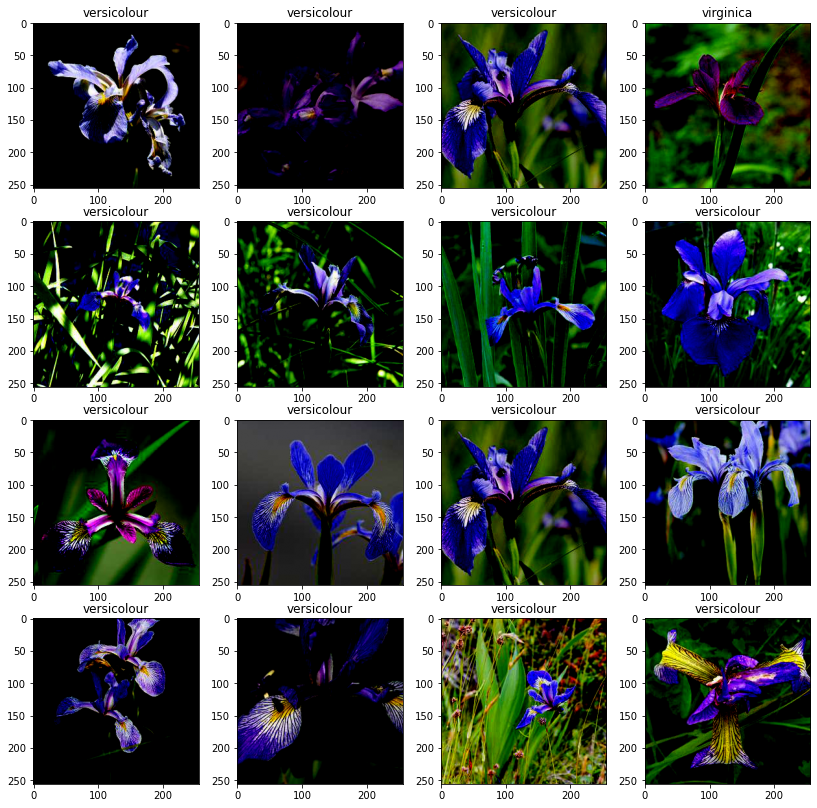

In [13]:
dataLoader(path = '../input/iris-computer-vision/iris-setosa', className = 'setosa')
dataLoader(path = '../input/iris-computer-vision/iris-versicolour', className = 'versicolour')
dataLoader(path = '../input/iris-computer-vision/iris-virginica', className = 'virginica')
numImages = visualizer()

In [14]:
desc = BuildDescriminator()
gen = BuildGenerator()
cGan = MakeCgan(gen, desc)


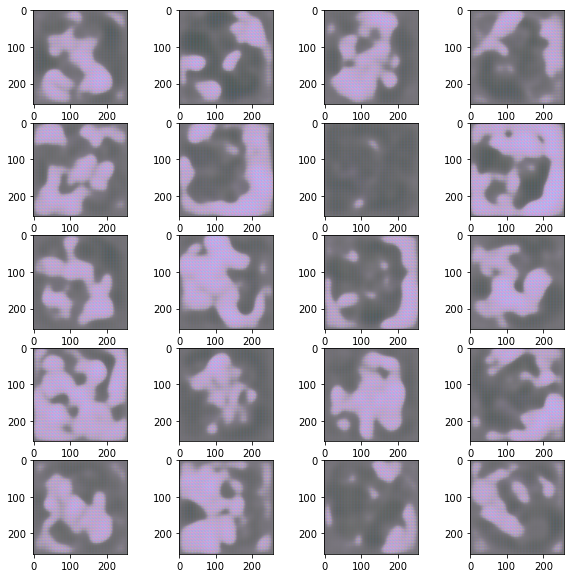

generator loss = 0.6807662844657898
descriminator loss = 0.6932350695133209
descriminator Acc = 0.5
Time for this epoch (in minutes) = 1.7126408364666683


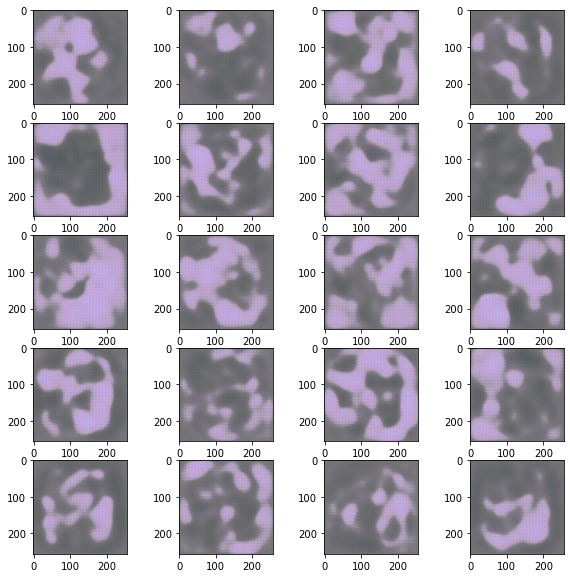

generator loss = 0.6819486021995544
descriminator loss = 0.6932212114334106
descriminator Acc = 0.5
Time for this epoch (in minutes) = 3.4340150613833353


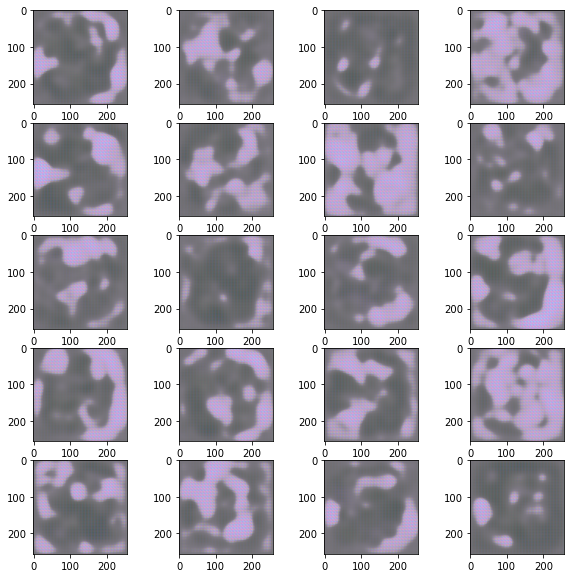

generator loss = 0.683017909526825
descriminator loss = 0.6932097971439362
descriminator Acc = 0.5
Time for this epoch (in minutes) = 5.1585980751000005


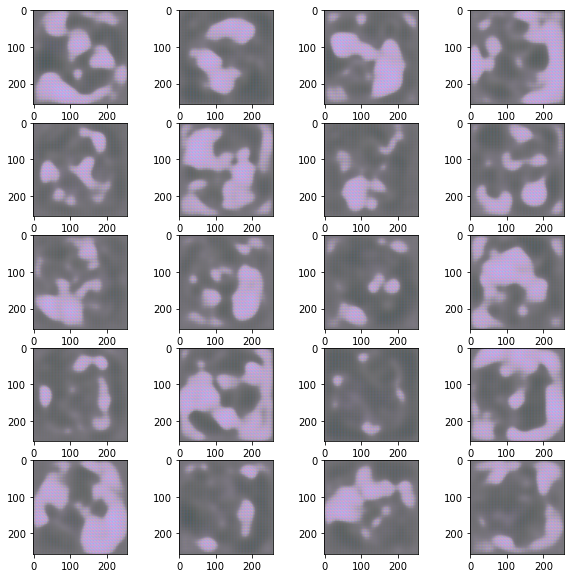

generator loss = 0.6839852333068848
descriminator loss = 0.693200558423996
descriminator Acc = 0.5
Time for this epoch (in minutes) = 6.886817990183332


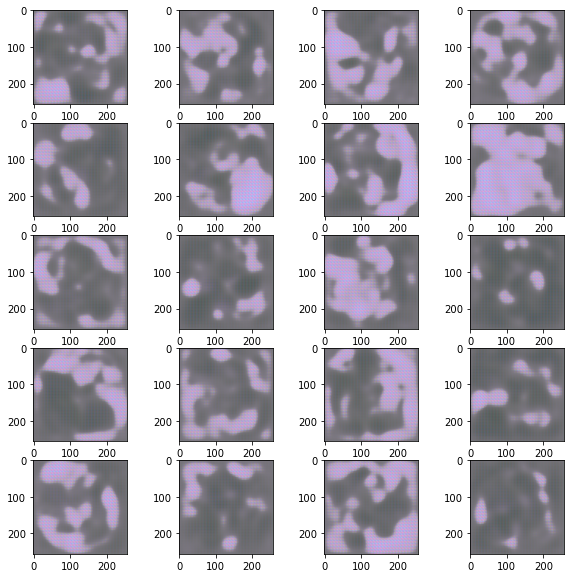

generator loss = 0.6848602294921875
descriminator loss = 0.6931929588317871
descriminator Acc = 0.5
Time for this epoch (in minutes) = 8.607546296133334


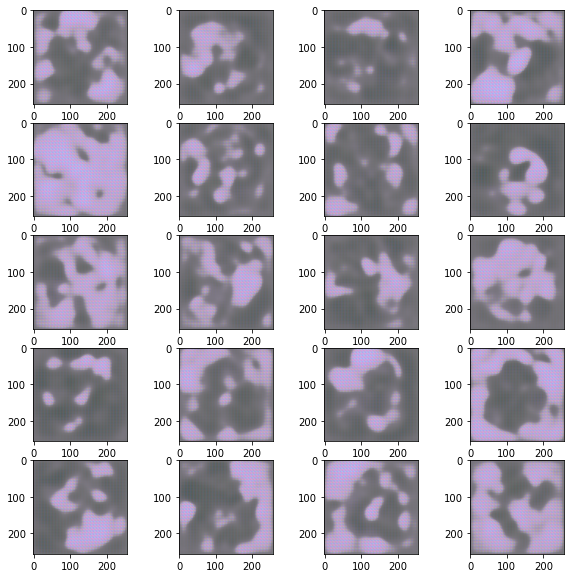

generator loss = 0.6856518387794495
descriminator loss = 0.69318687915802
descriminator Acc = 0.5
Time for this epoch (in minutes) = 10.333847644150001


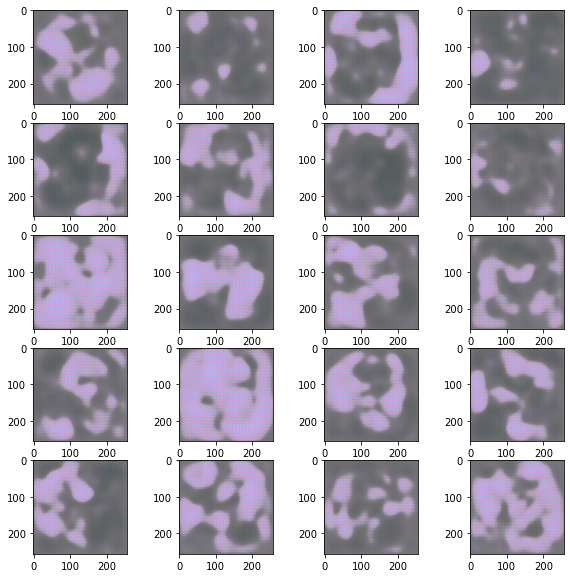

generator loss = 0.686367928981781
descriminator loss = 0.6931819319725037
descriminator Acc = 0.5
Time for this epoch (in minutes) = 12.067133154166664


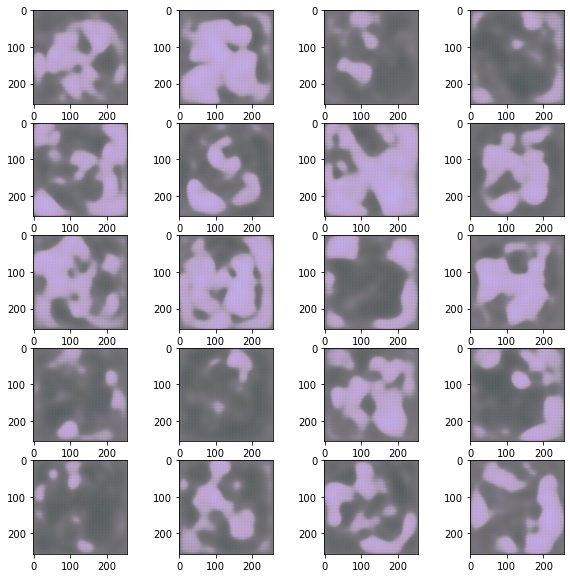

generator loss = 0.6870160102844238
descriminator loss = 0.6931778192520142
descriminator Acc = 0.5
Time for this epoch (in minutes) = 13.79051744678333


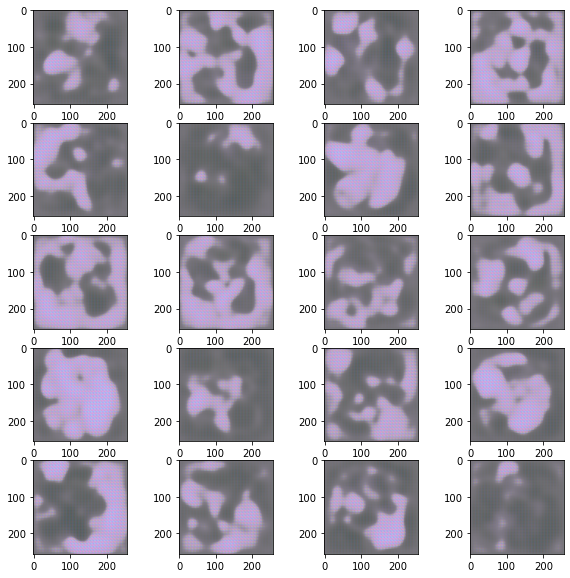

generator loss = 0.687602162361145
descriminator loss = 0.6931745111942291
descriminator Acc = 0.5
Time for this epoch (in minutes) = 15.5021916459


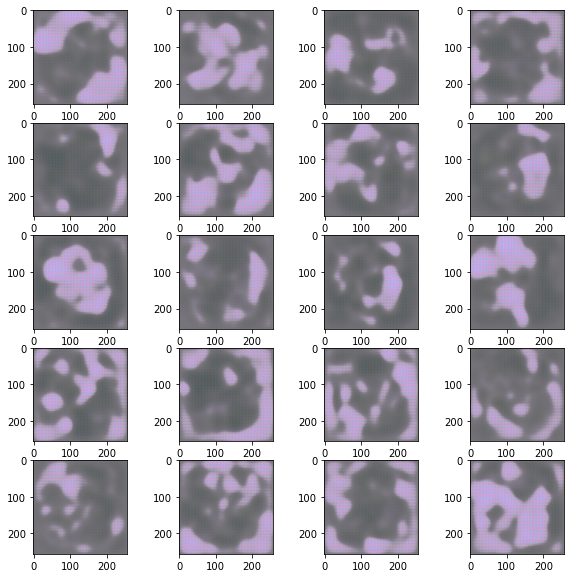

generator loss = 0.6881324052810669
descriminator loss = 0.6931718587875366
descriminator Acc = 0.5
Time for this epoch (in minutes) = 17.226374559883332


17.226374559883332

In [20]:
## 1000 epochs for training
## showing Result at every 100 epoch
Trainer(gen,desc,numImages,epochs = 1000, showAfter = 100)

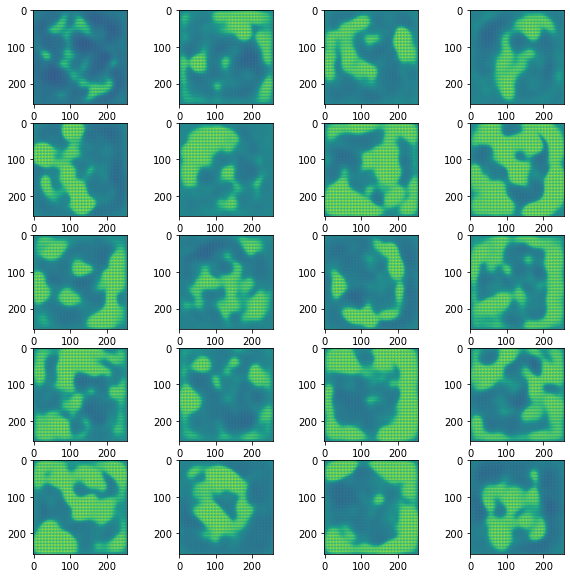

In [21]:
def GanViz2(gen):
    noise = np.random.normal(0, 1, (20, 100))
    genImgs = gen.predict(noise)
    genImgs = 0.5*genImgs + 0.5
    pltNum = 1
    
    plt.figure(figsize = (10, 10))
    for i in range(20):
        plt.subplot(5, 4, pltNum)
        #imgMerged = cv2.merge(, genImgs[i,:,:,1], genImgs[i,:,:,2]))
        plt.imshow(genImgs[i,:,:,0])
        
        pltNum += 1
    
    plt.show()

GanViz2(gen)

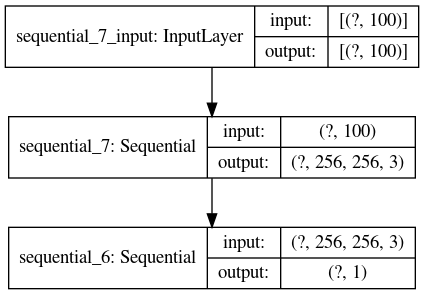

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(cGan, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

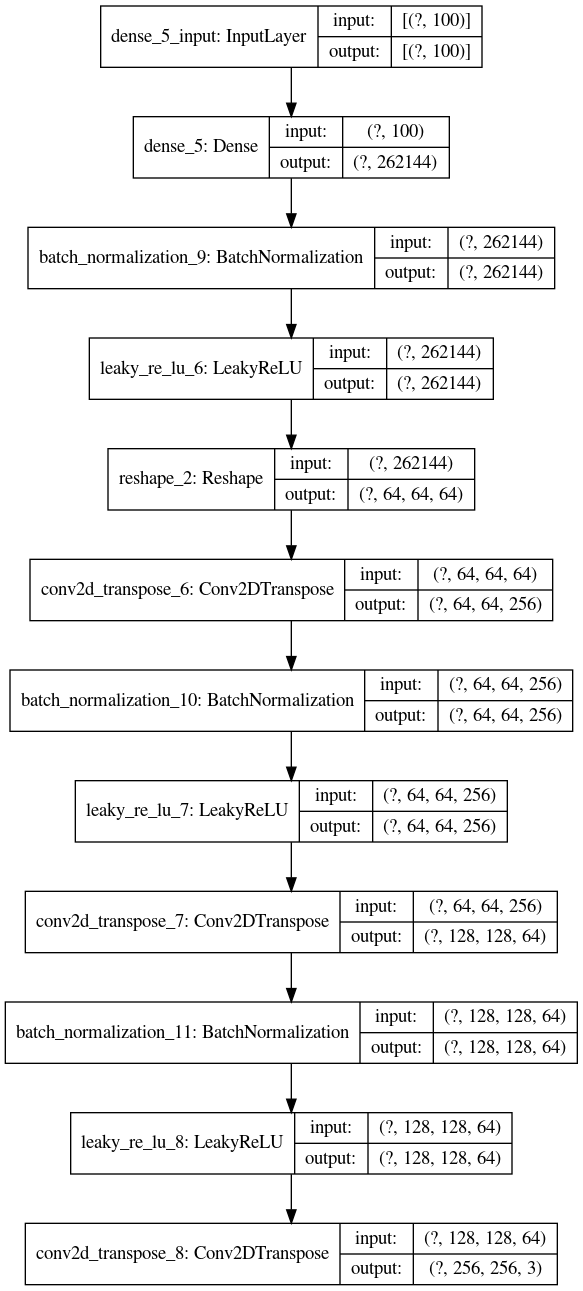

In [18]:
plot_model(gen, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

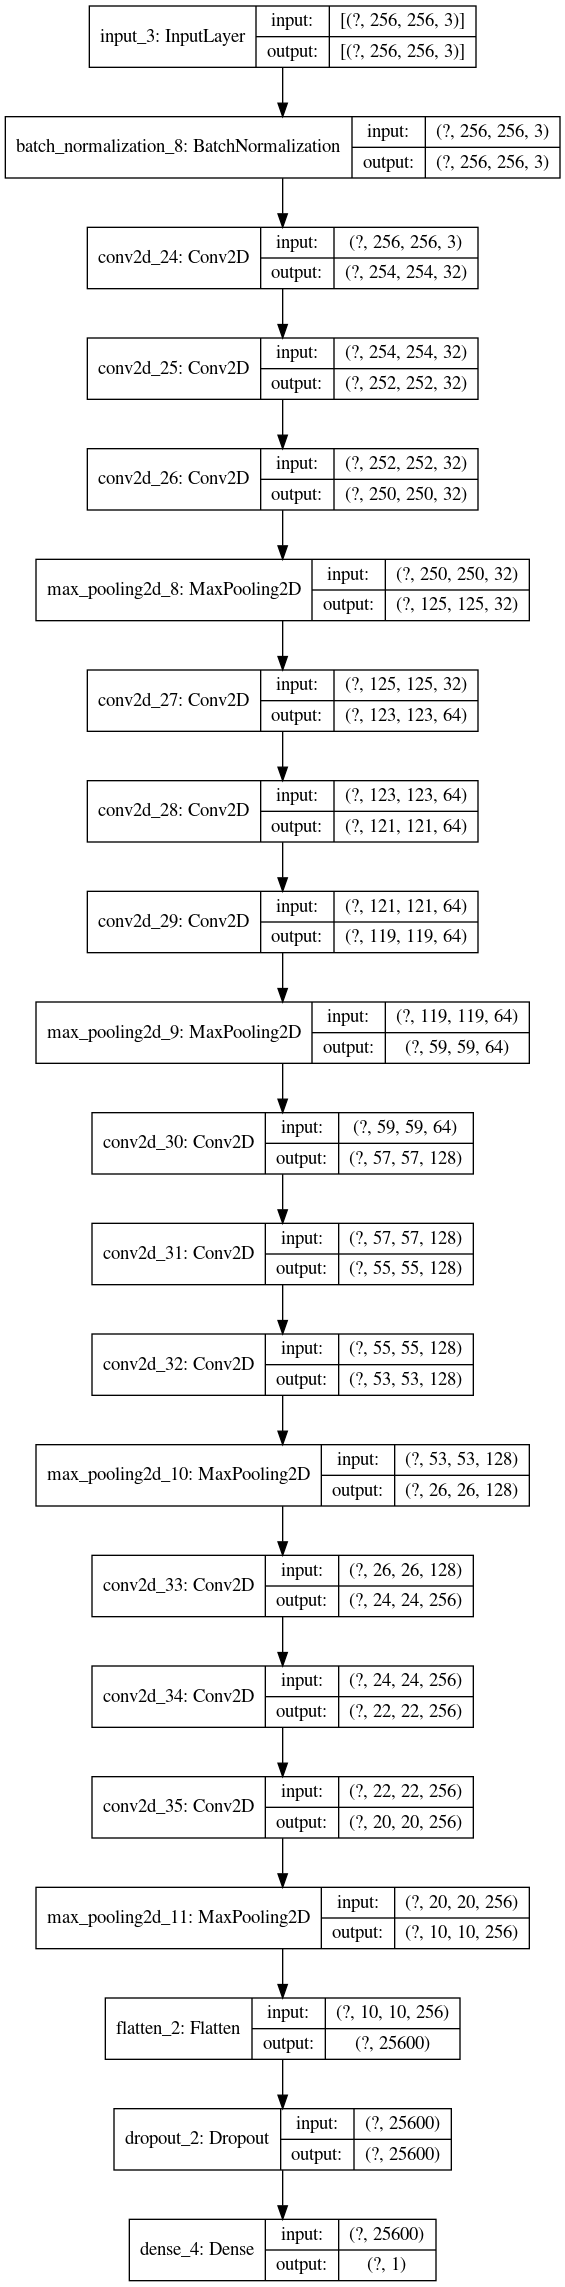

In [19]:
plot_model(desc, to_file='model_plot.png', show_shapes=True, show_layer_names=True)